In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import os
import sys
import torch
from PIL import Image
import cv2

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/stormer/')
from stormer_utils_pangu import StormerWrapperPangu
from varsStormer import varsStormer

/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
#save_dir = '/eagle/MDClimSim/mjp5595/ml4dvar/plots/stormer3D_12hrInit/'
save_dir = '/eagle/MDClimSim/mjp5595/ml4dvar/plots/stormer_var_check/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def read_era5(data,vars_stormer):
    data_np = np.zeros((len(vars_stormer),128,256))
    for i,var in enumerate(vars_stormer):
        data_np[i] = data['input/{}'.format(var)][:]
    return data_np

vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

means_file = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz'
stds_file = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz'
means = np.load(means_file)
stds = np.load(stds_file)

ana_fc_f = '/eagle/MDClimSim/mjp5595/data/stormer/var3d_era5B_era5Obs_gpu0/data/raw_forecasts_0_1201012014.h5'
ana_std_fc_f = '/eagle/MDClimSim/mjp5595/data/stormer/var3d_era5B_era5Obs_gpu0/data/forecasts_0_1201012014.h5'
bg_fc_f = '/eagle/MDClimSim/mjp5595/data/stormer/stormer_init_12hr_forecast/raw_0002.h5'
gtpred_f = '/eagle/MDClimSim/mjp5595/data/stormer/stormer_forecasts_2017_norm/raw_0002.h5'

ana_fc = h5py.File(ana_fc_f)
ana_std_fc = h5py.File(ana_std_fc_f)
bg_fc = h5py.File(bg_fc_f)
gtpred = h5py.File(gtpred_f)

lat = np.linspace(-90,90,128)
lon = np.linspace(0,360,256)

### Plot Background Forecast vs Analysis Forecast

In [ ]:
forecast_scales = [0,24,72,168]

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    era5_var_lim_min = float(np.inf)
    era5_var_lim_max = float(-np.inf)

    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    inc_mse_max = 0
    for fs in forecast_scales:
        #var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]),np.min(ana_fc[str(fs)][var_idx]))
        #var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]),np.max(ana_fc[str(fs)][var_idx]))
        era5_var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]))
        era5_var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]))
        var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]),np.min(ana_fc[str(fs)][var_idx]))
        var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]),np.max(ana_fc[str(fs)][var_idx]))

        inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
        inc_mse_max = max(inc_mse_max,np.mean(np.square(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx])))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    axs_mses = []
    mse_x = []
    mse_y = []
    fig, axs = plt.subplots(4, 3, sharex = True, sharey = False, figsize=(15,12))
    for i,fs in enumerate(forecast_scales):
        pc_era50 = axs[i,0].pcolormesh(lon, lat, bg_fc[str(fs)][var_idx], cmap='viridis', vmin=era5_var_lim_min, vmax=era5_var_lim_max)
        plt.colorbar(pc_era50, ax = axs[i, 0],label=vars_units[var_idx])
        axs[i, 0].set_title('Background Forecast {}hrs'.format(fs))
        axs[i, 0].set_xticks(np.linspace(0,360,9))

        #pc_ana0 = axs[i,1].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        pc_ana0 = axs[i,1].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx], cmap='viridis')
        plt.colorbar(pc_ana0, ax = axs[i, 1],label=vars_units[var_idx])
        axs[i, 1].set_title('Analysis Forecast {}hrs'.format(fs))
        axs[i, 1].set_xticks(np.linspace(0,360,9))
        axs[i, 1].get_yaxis().set_ticklabels([])

        pc_inc0 = axs[i,2].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx], 
                                    cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_inc0, ax = axs[i, 2], label=vars_units[var_idx])
        axs[i, 2].set_title('Increment (ana-bg) {}hrs'.format(fs))
        axs[i, 2].set_yticks([])
        axs[i, 2].set_xticks(np.linspace(0,360,9))

        axs_mses.append(axs[i,2].twinx())
        axs_mses[-1].set_ylim(0,inc_mse_max)
        axs_mses[-1].yaxis.tick_left()
        axs_mses[-1].yaxis.set_label_position('left')
        axs_mses[-1].set_ylabel('Mean Squared Increment ({})'.format(vars_units[var_idx]))
        mse_x.append(i*(359/(len(forecast_scales)-1)))
        mse_y.append(np.mean(np.square(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx])))
        axs_mses[-1].plot(mse_x,mse_y,c='k')

    fig.suptitle('Stormer3DVar Ana Vs Bg Forecasts ({})'.format(vars_stormer[var_idx]))
    plt.tight_layout()

    gif_dir = os.path.join(save_dir,'stormer3d_ana_vs_bg_forecasts_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)
    plt.savefig(os.path.join(gif_dir,'stormer3d_ana_vs_bg_forecasts_{}.png'.format(vars_stormer[var_idx])))

### Make Background Forecast vs Analysis Forecast GIF

In [ ]:
forecast_scales = np.arange(0,246,6)

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])
    gif_files = []
    gif_dir = os.path.join(save_dir,'stormer3d_ana_vs_bg_forecasts_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    era5_var_lim_min = float(np.inf)
    era5_var_lim_max = float(-np.inf)

    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    inc_mse_max = 0
    for fs in forecast_scales:
        #var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]),np.min(ana_fc[str(fs)][var_idx]))
        #var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]),np.max(ana_fc[str(fs)][var_idx]))
        era5_var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]))
        era5_var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]))
        var_lim_min = min(var_lim_min,np.min(bg_fc[str(fs)][var_idx]),np.min(ana_fc[str(fs)][var_idx]))
        var_lim_max = max(var_lim_max,np.max(bg_fc[str(fs)][var_idx]),np.max(ana_fc[str(fs)][var_idx]))

        inc_lim_min = min(inc_lim_min,np.min(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx]))
        inc_mse_max = max(inc_mse_max,np.mean(np.square(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx])))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    mse_x = []
    mse_y = []
    for i,fs in enumerate(forecast_scales):
        fig_gif, axs_gif = plt.subplots(1,3,sharex = True, sharey = False, figsize=(15,4))
        pc_era50 = axs_gif[0].pcolormesh(lon, lat, bg_fc[str(fs)][var_idx], cmap='viridis', vmin=era5_var_lim_min, vmax=era5_var_lim_max)
        plt.colorbar(pc_era50, ax = axs_gif[0],label=vars_units[var_idx])
        axs_gif[0].set_title('Background Forecast {}hrs'.format(fs))
        axs_gif[0].set_xticks(np.linspace(0,360,9))

        #pc_ana0 = axs_gif[1].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        pc_ana0 = axs_gif[1].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx], cmap='viridis')
        plt.colorbar(pc_ana0, ax = axs_gif[1],label=vars_units[var_idx])
        axs_gif[1].set_title('Analysis Forecast {}hrs'.format(fs))
        axs_gif[1].get_yaxis().set_ticklabels([])

        pc_inc0 = axs_gif[2].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx], 
                                    cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_inc0, ax = axs_gif[2], label=vars_units[var_idx])
        axs_gif[2].set_title('Increment (ana-bg) {}hrs'.format(fs))
        axs_gif[2].set_yticks([])

        axs_mses = axs_gif[2].twinx()
        axs_mses.set_ylim(0,inc_mse_max)
        axs_mses.yaxis.tick_left()
        axs_mses.yaxis.set_label_position('left')
        axs_mses.set_ylabel('Mean Squared Increment ({})'.format(vars_units[var_idx]))
        mse_x.append(i*(359/(len(forecast_scales)-1)))
        mse_y.append(np.mean(np.square(ana_fc[str(fs)][var_idx]-bg_fc[str(fs)][var_idx])))
        axs_mses.plot(mse_x,mse_y,c='k')

        fig_gif.suptitle('Stormer3DVar Ana Vs Bg Forecasts ({})'.format(vars_stormer[var_idx]))
        plt.tight_layout()

        plt.savefig(os.path.join(gif_dir,'{}.png'.format(i)))
        plt.close()

        gif_files.append(os.path.join(gif_dir,'{}.png'.format(i)))

    frames_per_second = 6
    w, h = None, None
    for j,gif_f in enumerate(gif_files):
        frame = cv2.imread(gif_f)
        
        if w is None:
            h, w, _ = frame.shape
            fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
            writer = cv2.VideoWriter(os.path.join(gif_dir,'stormer3d_ana_vs_bg_forecasts_mp4.mp4'),
                                     fourcc,
                                     frames_per_second,
                                     (w,h),
                                     )
        writer.write(frame)
        if j == 0 or j == (len(gif_files)-1):
            for _ in range(frames_per_second):
                writer.write(frame)
    writer.release()

    gif_imgs = []
    for gif_f in gif_files:
        gif_imgs.append(Image.open(gif_f))

    # create extra copies of the frist and last frame
    for x in range(0, 5):
        im = gif_imgs[0]
        gif_imgs.insert(0,im)
        im = gif_imgs[-1]
        gif_imgs.append(im)

    gif_imgs[0].save(os.path.join(gif_dir,'stormer3d_ana_vs_bg_forecasts_gif.gif'),
                save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)

### Plot Analysis Forecast vs ERA5 GT

In [ ]:
ana_vs_gt_dir = os.path.join(save_dir,'ana_vs_gt')
if not os.path.exists(ana_vs_gt_dir):
    os.makedirs(ana_vs_gt_dir)

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format(2)),'r'),vars_stormer)
era5_std_data = read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format(2)),'r'),vars_stormer)
for v_idx,v in enumerate(vars_stormer):
    era5_std_data[v_idx] = (era5_std_data[v_idx]-means[v])/stds[v]

for v_idx,v in enumerate(vars_stormer):
    print('var :',v)

    fig, axs = plt.subplots(2, 3, sharex = True, sharey = True, figsize=(15,6))

    pc_gt = axs[0,0].pcolormesh(lon, lat, era5_data[v_idx], cmap='viridis')
    plt.colorbar(pc_gt, ax = axs[0, 0],label=vars_units[v_idx])
    axs[0, 0].set_title('Ground Truth')
    axs[0, 0].set_xticks(np.linspace(0,360,9))

    pc_ana = axs[0,1].pcolormesh(lon, lat, ana_fc['0'][v_idx], cmap='viridis')
    plt.colorbar(pc_ana, ax = axs[0, 1],label=vars_units[v_idx])
    axs[0, 1].set_title('Analysis')

    pc_inc = axs[0,2].pcolormesh(lon, lat, ana_fc['0'][v_idx]-era5_data[v_idx], 
                                cmap='RdYlBu_r')
    plt.colorbar(pc_inc, ax = axs[0, 2], label=vars_units[v_idx])
    axs[0, 2].set_title('Increment (ana - gt)')

    pc_gt = axs[1,0].pcolormesh(lon, lat, era5_std_data[v_idx], cmap='viridis')
    plt.colorbar(pc_gt, ax = axs[1, 0],label=vars_units[v_idx])
    axs[1, 0].set_title('Ground Truth Std')
    axs[1, 0].set_xticks(np.linspace(0,360,9))

    pc_ana = axs[1,1].pcolormesh(lon, lat, ana_std_fc['0'][v_idx], cmap='viridis')
    plt.colorbar(pc_ana, ax = axs[1, 1],label=vars_units[v_idx])
    axs[1, 1].set_title('Analysis Std')

    pc_inc = axs[1,2].pcolormesh(lon, lat, ana_std_fc['0'][v_idx]-era5_std_data[v_idx], 
                                cmap='RdYlBu_r')
    plt.colorbar(pc_inc, ax = axs[1, 2], label=vars_units[v_idx])
    axs[1, 2].set_title('Increment Std (ana - gt)')

    #print('Analysis vs Ground Truth ({})\nMean : {:0>2f}, Std : {:0>2f}'.format(vars_stormer[v_idx],means[v][0],stds[v][0]))
    fig.suptitle('Analysis vs Ground Truth ({})\nMean : {:0>2f}, Std : {:0>2f}'.format(vars_stormer[v_idx],means[v][0],stds[v][0]))
    plt.tight_layout()

    plt.savefig(os.path.join(ana_vs_gt_dir,'{}.png'.format(vars_stormer[v_idx])))

### Make Analysis Forecast vs GT GIF

In [6]:
forecast_scales = np.arange(0,246,6)

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = []
for fs in forecast_scales:
    #print('loading fs_scale :',fs)
    era5_data.append(read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format((fs//6)+2)),'r'),vars_stormer))

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])

    gif_files = []
    gif_dir = os.path.join(save_dir,'stormer3d_ana_vs_gt_forecasts_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    for i,fs in enumerate(forecast_scales):
        var_lim_min = min(var_lim_min,np.min(ana_fc[str(fs)][var_idx]),np.min(era5_data[i][var_idx]))
        var_lim_max = max(var_lim_max,np.max(ana_fc[str(fs)][var_idx]),np.max(era5_data[i][var_idx]))
        inc_lim_min = min(inc_lim_min,np.min(era5_data[i][var_idx]-ana_fc[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(era5_data[i][var_idx]-ana_fc[str(fs)][var_idx]))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    for i,fs in enumerate(forecast_scales):
        fig_gif, axs_gif = plt.subplots(1,3,sharex = True, sharey = True, figsize=(15,4))
        pc_era50 = axs_gif[0].pcolormesh(lon, lat, era5_data[i][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_era50, ax = axs_gif[0],label=vars_units[var_idx])
        axs_gif[0].set_title('Ground Truth {}hrs'.format(fs))
        axs_gif[0].set_xticks(np.linspace(0,360,9))

        pc_ana0 = axs_gif[1].pcolormesh(lon, lat, ana_fc[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_ana0, ax = axs_gif[1],label=vars_units[var_idx])
        axs_gif[1].set_title('Analysis Forecast {}hrs'.format(fs))

        pc_inc0 = axs_gif[2].pcolormesh(lon, lat, era5_data[i][var_idx]-ana_fc[str(fs)][var_idx], 
                                    cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_inc0, ax = axs_gif[2], label=vars_units[var_idx])
        axs_gif[2].set_title('Increment (ana-bg) {}hrs'.format(fs))

        fig_gif.suptitle('Stormer Analysis Forecast Vs Ground Truth ({})'.format(vars_stormer[var_idx]))
        plt.tight_layout()

        plt.savefig(os.path.join(gif_dir,'{}.png'.format(i)))
        plt.close()

        gif_files.append(os.path.join(gif_dir,'{}.png'.format(i)))

    frames_per_second = 6
    w, h = None, None
    for j,gif_f in enumerate(gif_files):
        frame = cv2.imread(gif_f)
        
        if w is None:
            h, w, _ = frame.shape
            fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
            writer = cv2.VideoWriter(os.path.join(gif_dir,'stormer3d_ana_vs_gt_forecasts_mp4.mp4'),
                                     fourcc,
                                     frames_per_second,
                                     (w,h),
                                     )
        writer.write(frame)
        if j == 0 or j == (len(gif_files)-1):
            for _ in range(frames_per_second):
                writer.write(frame)
    writer.release()

    gif_imgs = []
    for gif_f in gif_files:
        gif_imgs.append(Image.open(gif_f))

    # create extra copies of the frist and last frame
    for x in range(0, 5):
        im = gif_imgs[0]
        gif_imgs.insert(0,im)
        im = gif_imgs[-1]
        gif_imgs.append(im)

    gif_imgs[0].save(os.path.join(gif_dir,'stormer3d_ana_vs_gt_forecasts_gif.gif'),
                save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)

var : 2m_temperature
var : mean_sea_level_pressure
var : geopotential_500


### Plot Background Forecast vs ERA5 GT

var : 2m_temperature
var : mean_sea_level_pressure
var : geopotential_500


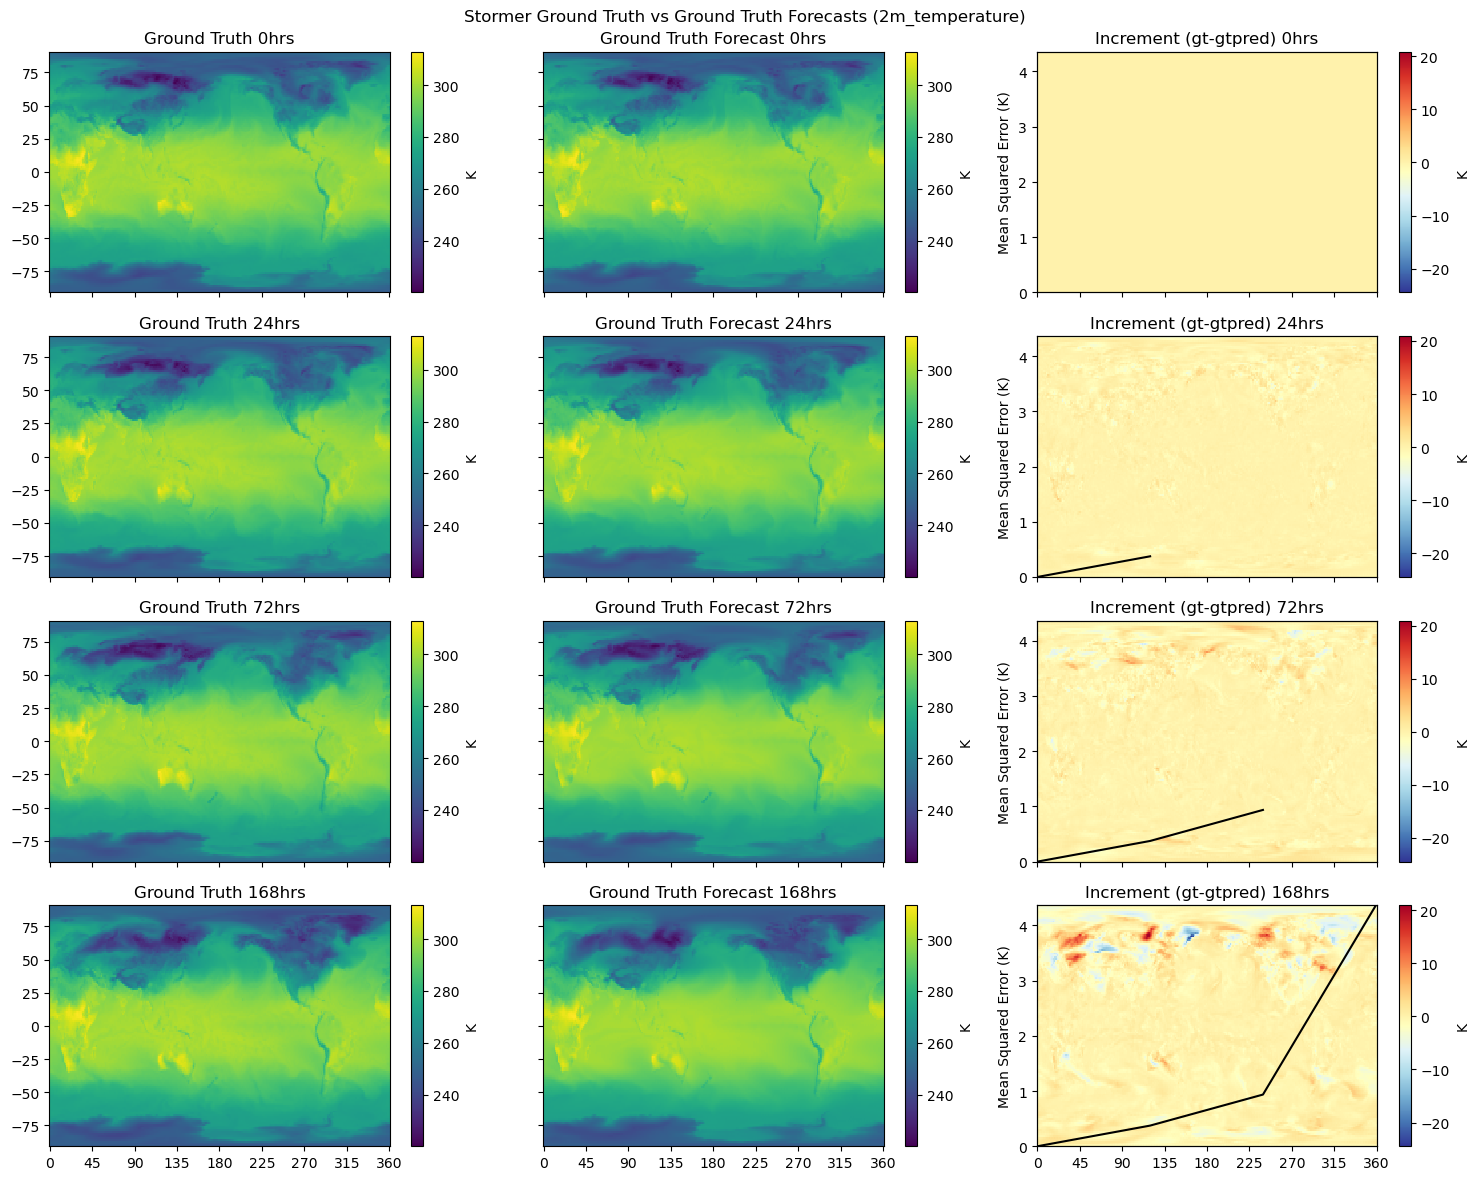

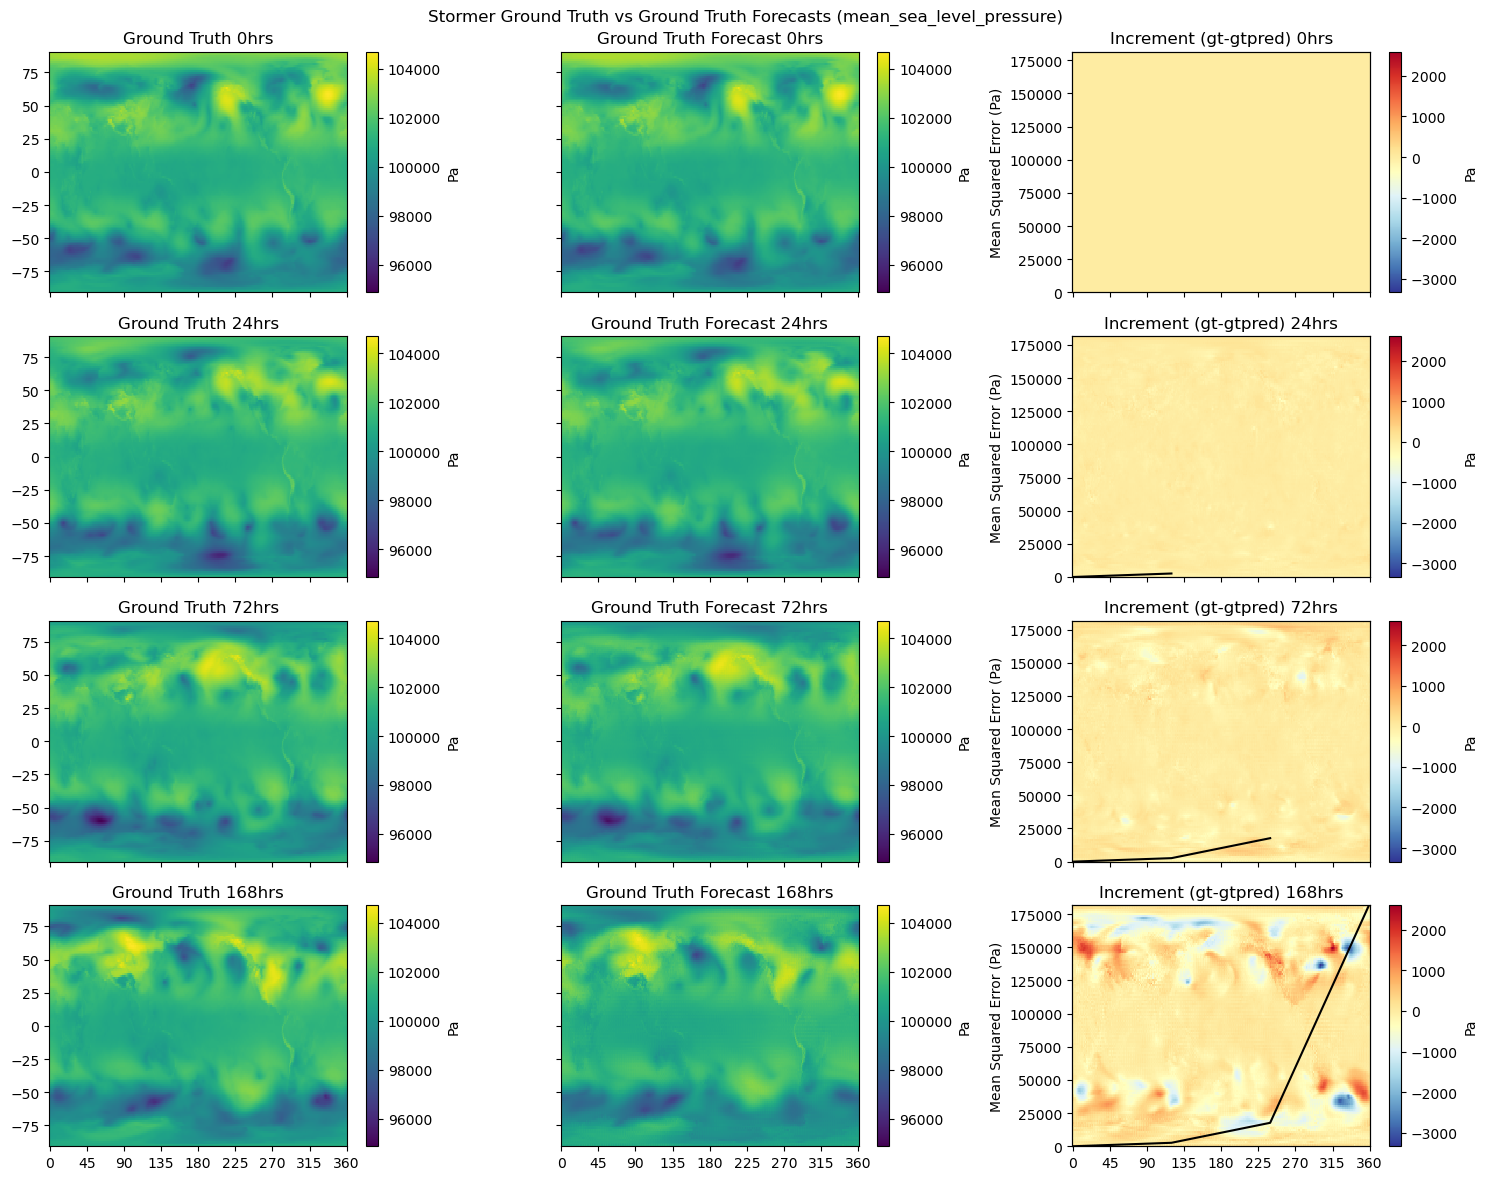

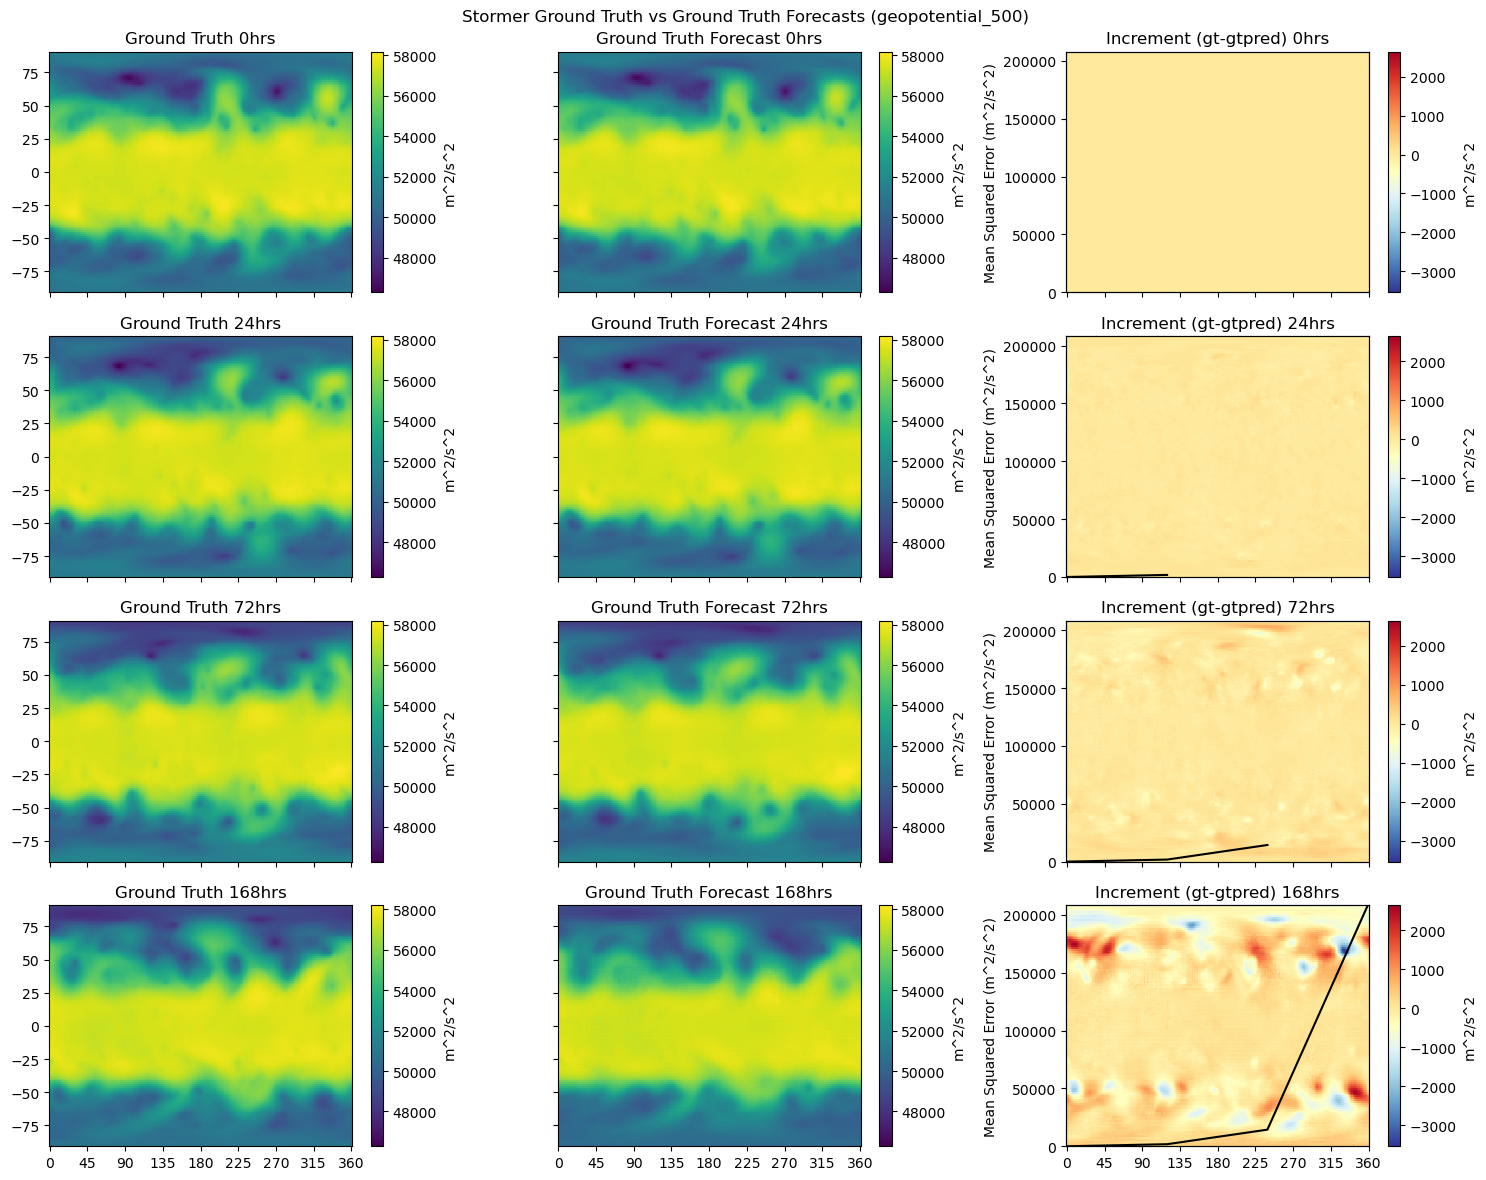

In [7]:
forecast_scales = [0,24,72,168]

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = []
for fs in forecast_scales:
    #print('loading fs_scale :',fs)
    era5_data.append(read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format((fs//6)+2)),'r'),vars_stormer))

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])
    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    inc_mse_max = 0
    for i,fs in enumerate(forecast_scales):
        var_lim_min = min(var_lim_min,np.min(gtpred[str(fs)][var_idx]),np.min(era5_data[i][var_idx]))
        var_lim_max = max(var_lim_max,np.max(gtpred[str(fs)][var_idx]),np.max(era5_data[i][var_idx]))

        inc_lim_min = min(inc_lim_min,np.min(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
        inc_mse_max = max(inc_mse_max,np.mean(np.square(era5_data[i][var_idx]-gtpred[str(fs)][var_idx])))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    axs_mses = []
    mse_x = []
    mse_y = []
    fig, axs = plt.subplots(4, 3, sharex = True, sharey = False, figsize=(15,12))
    for i,fs in enumerate(forecast_scales):
        pc_ana0 = axs[i,0].pcolormesh(lon, lat, era5_data[i][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_ana0, ax = axs[i, 0],label=vars_units[var_idx])
        axs[i, 0].set_title('Ground Truth {}hrs'.format(fs))
        axs[i, 0].set_xticks(np.linspace(0,360,9))

        pc_era50 = axs[i,1].pcolormesh(lon, lat, gtpred[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_era50, ax = axs[i, 1],label=vars_units[var_idx])
        axs[i, 1].set_title('Ground Truth Forecast {}hrs'.format(fs))
        axs[i, 1].set_yticklabels([])

        pc_inc0 = axs[i,2].pcolormesh(lon, lat, era5_data[i][var_idx]-gtpred[str(fs)][var_idx], 
                                    cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_inc0, ax = axs[i, 2], label=vars_units[var_idx])
        axs[i, 2].set_title('Increment (gt-gtpred) {}hrs'.format(fs))
        axs[i, 2].set_yticks([])

        axs_mses.append(axs[i,2].twinx())
        axs_mses[-1].set_ylim(0,inc_mse_max)
        axs_mses[-1].yaxis.tick_left()
        axs_mses[-1].yaxis.set_label_position('left')
        axs_mses[-1].set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
        mse_x.append(i*(359/(len(forecast_scales)-1)))
        mse_y.append(np.mean(np.square(era5_data[i][var_idx]-gtpred[str(fs)][var_idx])))
        axs_mses[-1].plot(mse_x,mse_y,c='k')

    fig.suptitle('Stormer Ground Truth vs Ground Truth Forecasts ({})'.format(vars_stormer[var_idx]))
    plt.tight_layout()

    gif_dir = os.path.join(save_dir,'stormer3d_gt_vs_gtpred_forecasts_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)
    plt.savefig(os.path.join(gif_dir,'stormer3d_gt_gtpred_forecasts_{}.png'.format(vars_stormer[var_idx])))

### Make Ground Truth Forecast vs Ground Truth GIF

In [8]:
forecast_scales = np.arange(0,246,6)

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = []
for fs in forecast_scales:
    #print('loading fs_scale :',fs)
    era5_data.append(read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format((fs//6)+2)),'r'),vars_stormer))

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])

    gif_files = []
    gif_dir = os.path.join(save_dir,'stormer3d_gt_vs_gtpred_forecasts_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    inc_mse_max = 0
    for i,fs in enumerate(forecast_scales):
        var_lim_min = min(var_lim_min,np.min(gtpred[str(fs)][var_idx]),np.min(era5_data[i][var_idx]))
        var_lim_max = max(var_lim_max,np.max(gtpred[str(fs)][var_idx]),np.max(era5_data[i][var_idx]))
        inc_lim_min = min(inc_lim_min,np.min(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
        inc_mse_max = max(inc_mse_max,np.mean(np.square(era5_data[i][var_idx]-gtpred[str(fs)][var_idx])))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    mse_x = []
    mse_y = []
    for i,fs in enumerate(forecast_scales):
        fig_gif, axs_gif = plt.subplots(1,3,sharex = True, sharey = True, figsize=(15,4))
        pc_era50 = axs_gif[0].pcolormesh(lon, lat, era5_data[i][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_era50, ax = axs_gif[0],label=vars_units[var_idx])
        axs_gif[0].set_title('Ground Truth {}hrs'.format(fs))
        axs_gif[0].set_xticks(np.linspace(0,360,9))

        pc_ana0 = axs_gif[1].pcolormesh(lon, lat, gtpred[str(fs)][var_idx], cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_ana0, ax = axs_gif[1],label=vars_units[var_idx])
        axs_gif[1].set_title('Ground Truth Forecast {}hrs'.format(fs))

        pc_inc0 = axs_gif[2].pcolormesh(lon, lat, era5_data[i][var_idx]-gtpred[str(fs)][var_idx], 
                                    cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_inc0, ax = axs_gif[2], label=vars_units[var_idx])
        axs_gif[2].set_title('Increment (gt-gtpred) {}hrs'.format(fs))
        axs_gif[2].set_yticks([])

        axs_mses = axs_gif[2].twinx()
        axs_mses.set_ylim(0,inc_mse_max)
        axs_mses.yaxis.tick_left()
        axs_mses.yaxis.set_label_position('left')
        axs_mses.set_ylabel('Mean Squared Error ({})'.format(vars_units[var_idx]))
        mse_x.append(i*(359/(len(forecast_scales)-1)))
        mse_y.append(np.mean(np.square(era5_data[i][var_idx]-gtpred[str(fs)][var_idx])))
        axs_mses.plot(mse_x,mse_y,c='k')

        fig_gif.suptitle('Stormer Ground Truth vs Ground Truth Forecast ({})'.format(vars_stormer[var_idx]))
        plt.tight_layout()

        plt.savefig(os.path.join(gif_dir,'{}.png'.format(i)))
        plt.close()

        gif_files.append(os.path.join(gif_dir,'{}.png'.format(i)))

    frames_per_second = 6
    w, h = None, None
    for j,gif_f in enumerate(gif_files):
        frame = cv2.imread(gif_f)
        
        if w is None:
            h, w, _ = frame.shape
            fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
            writer = cv2.VideoWriter(os.path.join(gif_dir,'stormer3d_gt_vs_gtpred_forecasts_mp4.mp4'),
                                     fourcc,
                                     frames_per_second,
                                     (w,h),
                                     )
        
        writer.write(frame)
        if j == 0 or j == (len(gif_files)-1):
            for _ in range(frames_per_second):
                writer.write(frame)
    writer.release()

    gif_imgs = []
    for gif_f in gif_files:
        gif_imgs.append(Image.open(gif_f))

    # create extra copies of the frist and last frame
    for x in range(0, 5):
        im = gif_imgs[0]
        gif_imgs.insert(0,im)
        im = gif_imgs[-1]
        gif_imgs.append(im)

    gif_imgs[0].save(os.path.join(gif_dir,'stormer3d_gt_vs_gtpred_forecasts_gif.gif'),
                save_all=True, append_images=gif_imgs[1:], optimize=False, duration=250, loop=0)

var : 2m_temperature
var : mean_sea_level_pressure
var : geopotential_500


### Plot Background Forecast Increment vs Analysis Forecast Increment

var : 2m_temperature
var : mean_sea_level_pressure
var : geopotential_500


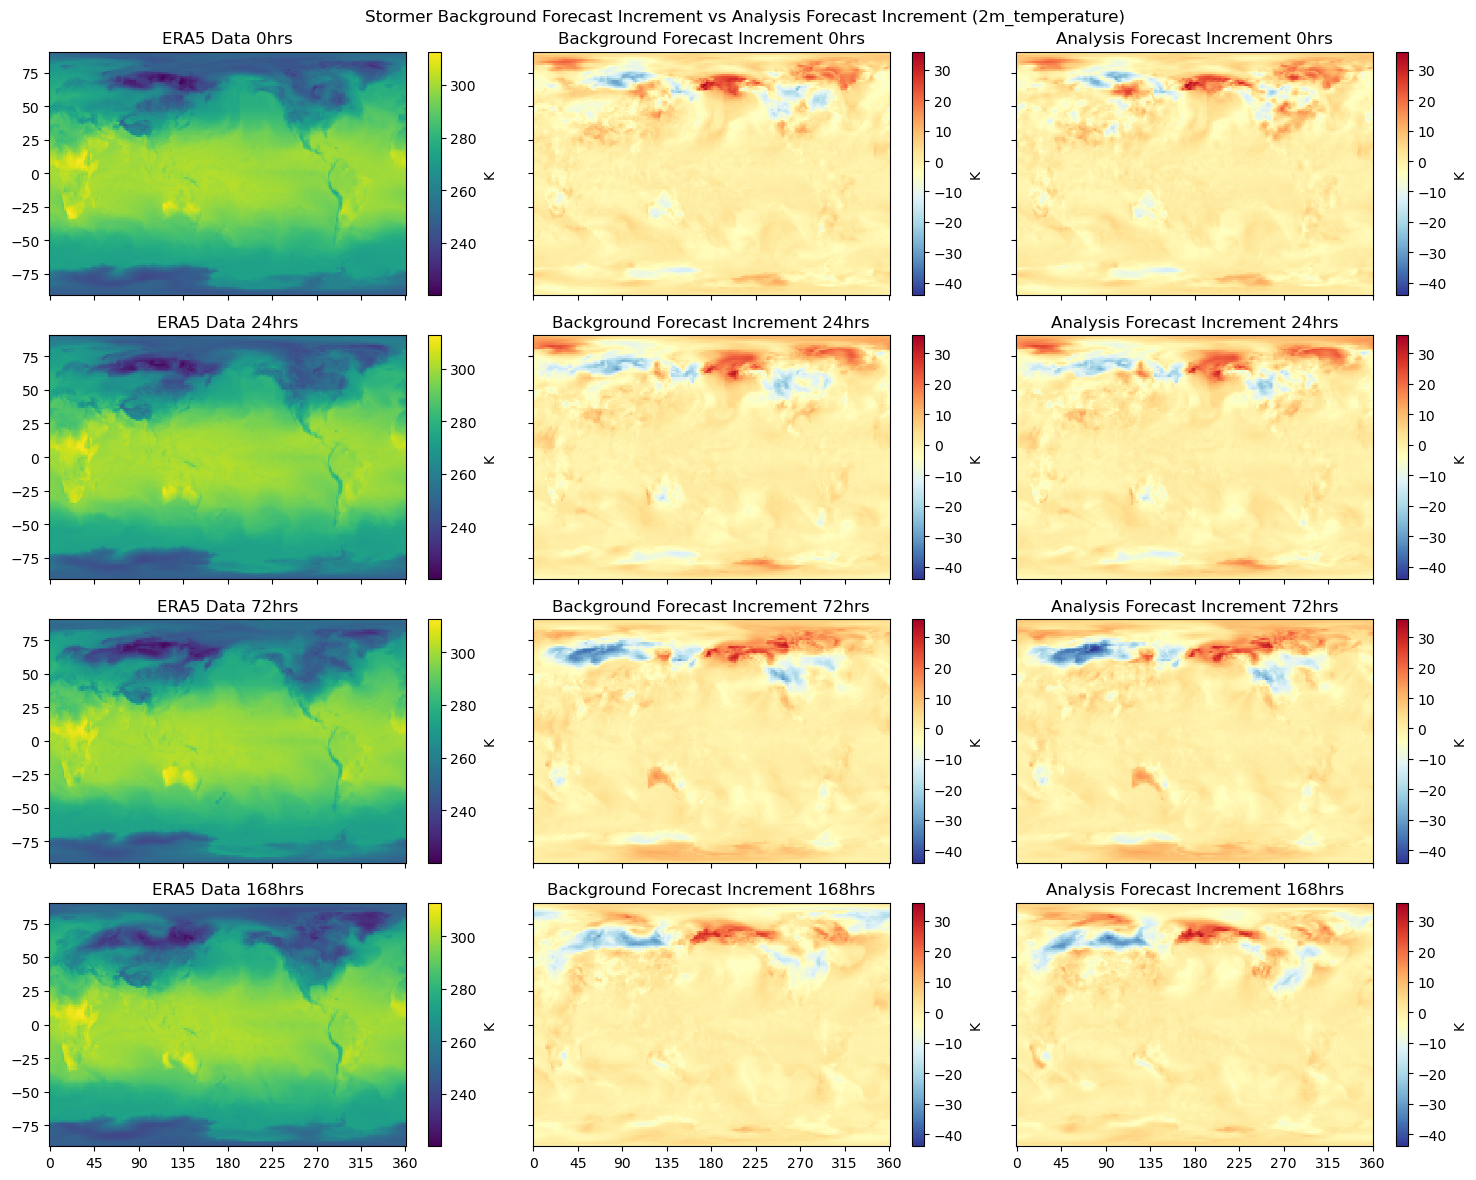

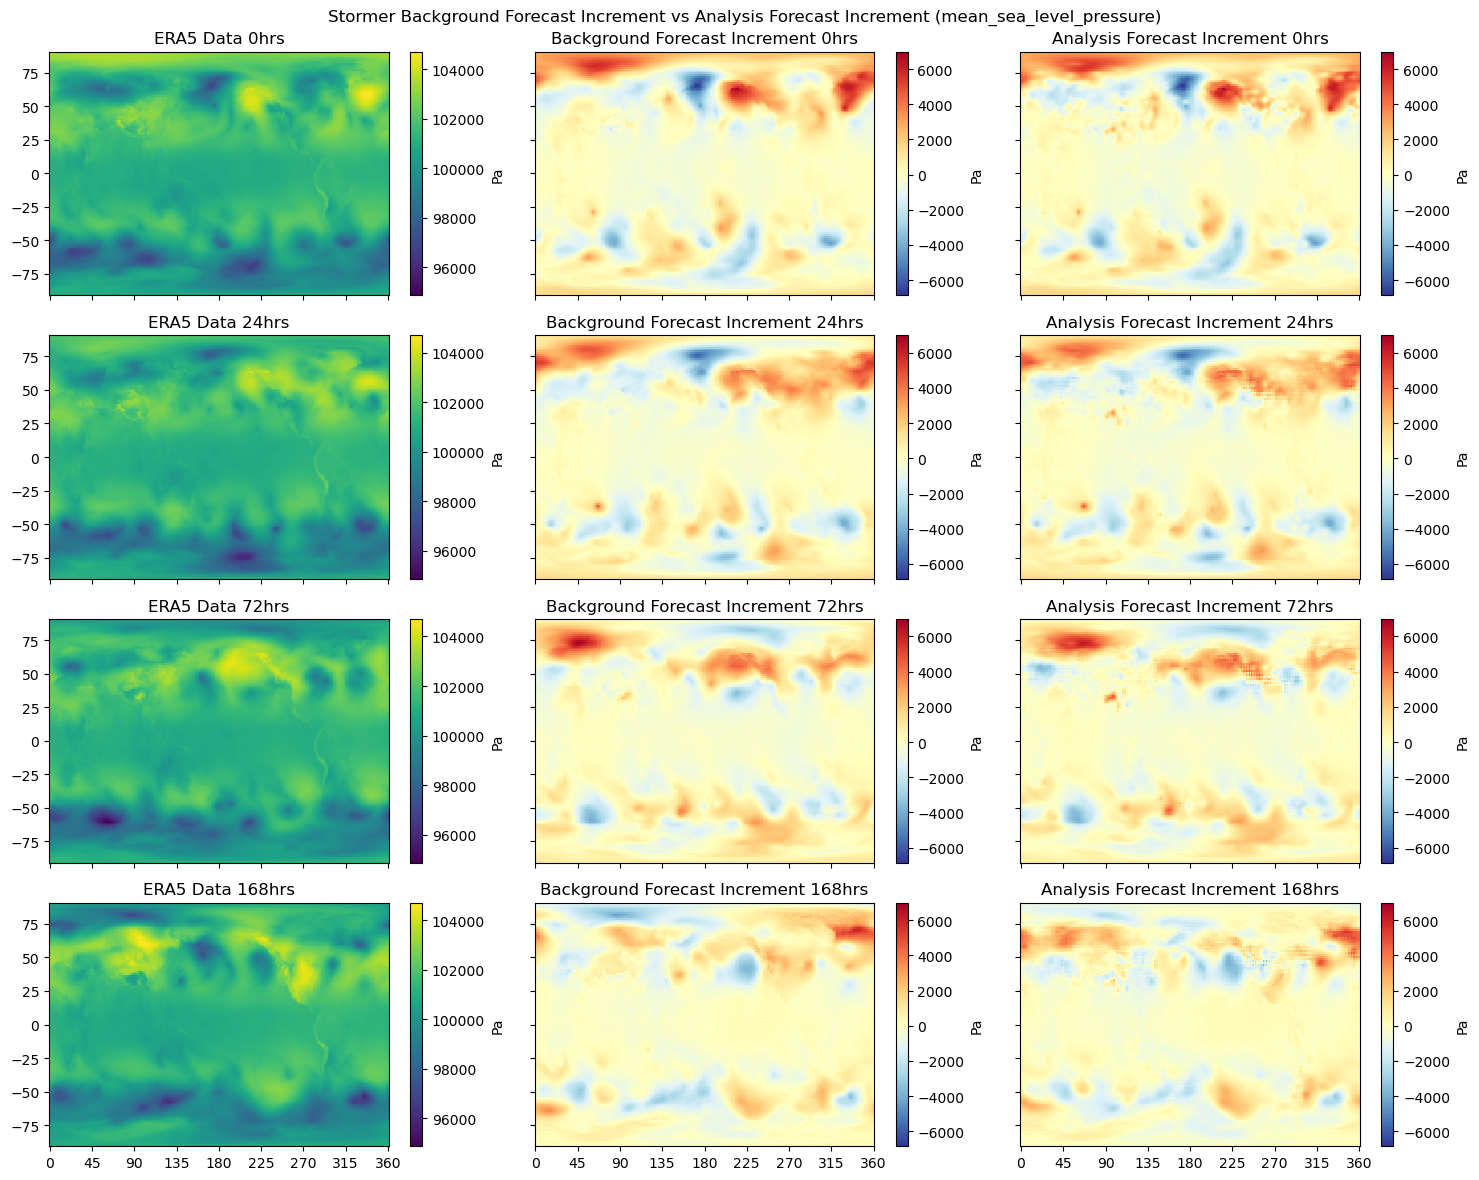

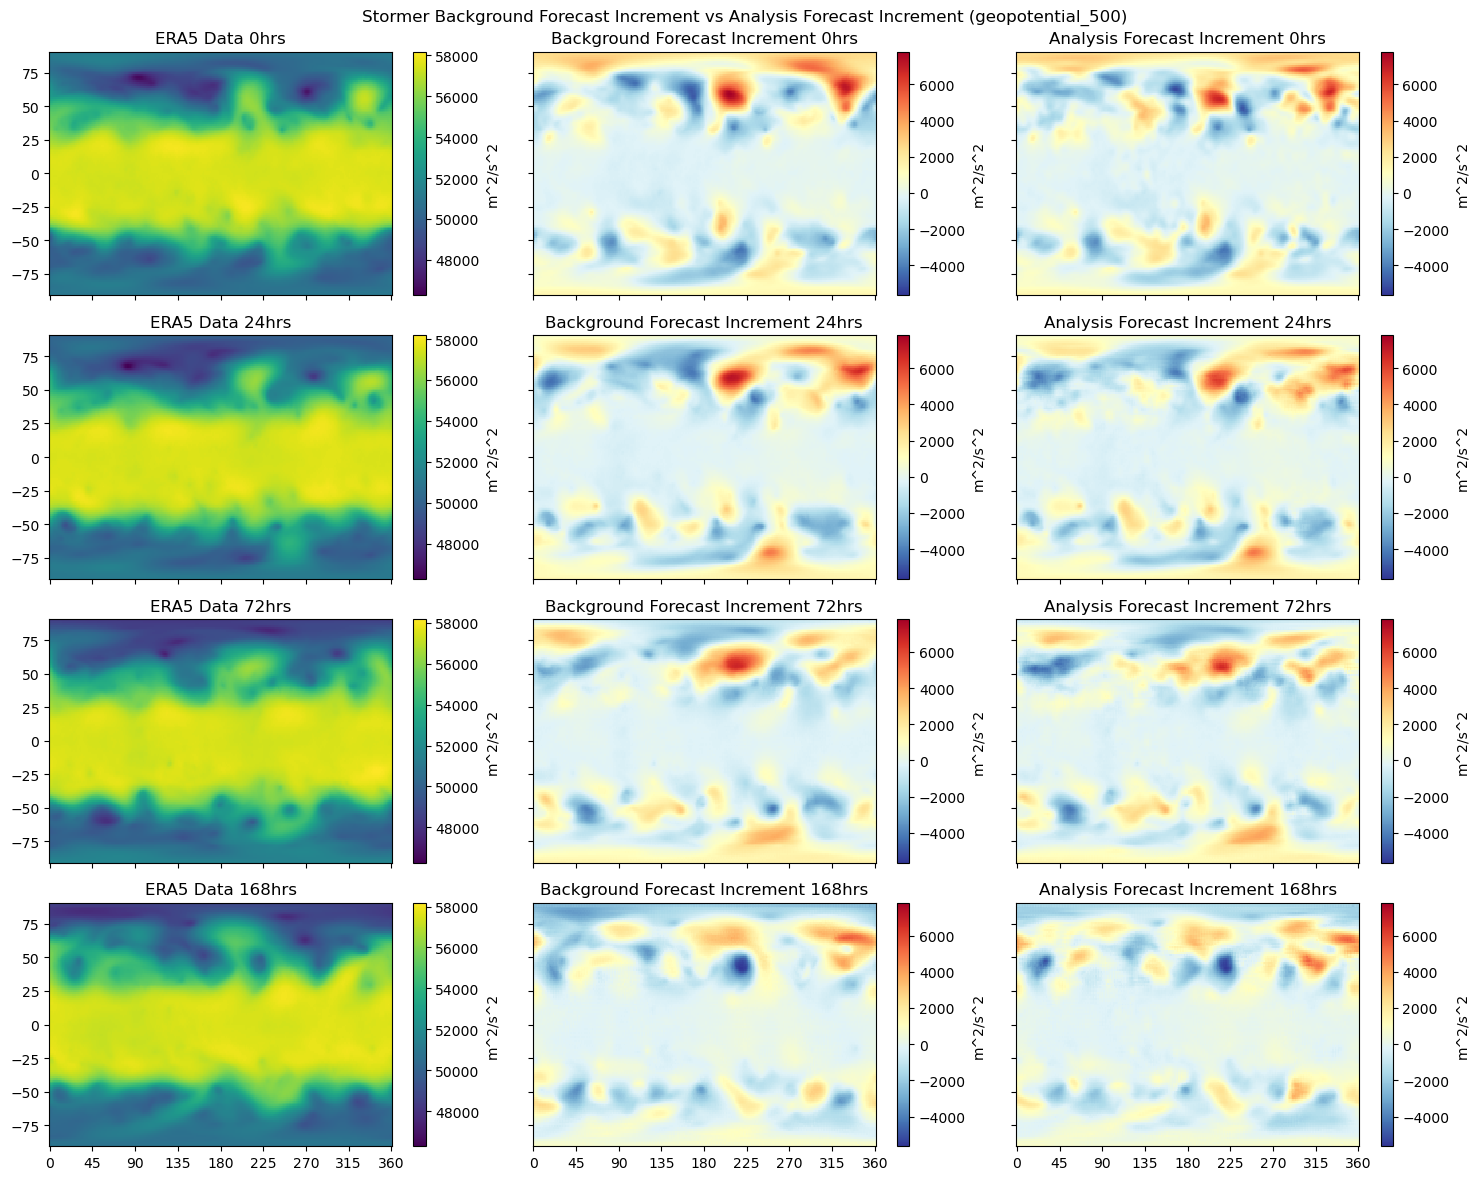

In [9]:
forecast_scales = [0,24,72,168]

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = []
for fs in forecast_scales:
    #print('loading fs_scale :',fs)
    era5_data.append(read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format((fs//6)+2)),'r'),vars_stormer))

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    for i,fs in enumerate(forecast_scales):
        var_lim_min = min(var_lim_min,np.min(era5_data[i][var_idx]))
        var_lim_max = max(var_lim_max,np.max(era5_data[i][var_idx]))
        inc_lim_min = min(inc_lim_min,np.min(era5_data[i][var_idx]-bg_fc[str(fs)][var_idx]),np.min(era5_data[i][var_idx]-ana_fc[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(era5_data[i][var_idx]-bg_fc[str(fs)][var_idx]),np.max(era5_data[i][var_idx]-ana_fc[str(fs)][var_idx]))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    fig, axs = plt.subplots(4, 3, sharex = True, sharey = True, figsize=(15,12))
    for i,fs in enumerate(forecast_scales):

        pc_inc0 = axs[i,0].pcolormesh(lon, lat, era5_data[i][var_idx], 
                                    cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_inc0, ax = axs[i, 0], label=vars_units[var_idx])
        axs[i, 0].set_title('ERA5 Data {}hrs'.format(fs))

        pc_ana0 = axs[i,1].pcolormesh(lon, lat, era5_data[i][var_idx]-bg_fc[str(fs)][var_idx], cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_ana0, ax = axs[i, 1],label=vars_units[var_idx])
        axs[i, 1].set_title('Background Forecast Increment {}hrs'.format(fs))
        axs[i, 1].set_xticks(np.linspace(0,360,9))

        pc_era50 = axs[i,2].pcolormesh(lon, lat, era5_data[i][var_idx]-ana_fc[str(fs)][var_idx], cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_era50, ax = axs[i, 2],label=vars_units[var_idx])
        axs[i, 2].set_title('Analysis Forecast Increment {}hrs'.format(fs))

    fig.suptitle('Stormer Background Forecast Increment vs Analysis Forecast Increment ({})'.format(vars_stormer[var_idx]))
    plt.tight_layout()

    gif_dir = os.path.join(save_dir,'stormer3d_bg_vs_ana_increments_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)
    plt.savefig(os.path.join(gif_dir,'stormer3d_bg_vs_ana_increments_{}.png'.format(vars_stormer[var_idx])))

### Make Background Forecast Increment vs Analysis Forecast Increment GIF

In [10]:
forecast_scales = np.arange(0,246,6)

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_data = []
for fs in forecast_scales:
    #print('loading fs_scale :',fs)
    era5_data.append(read_era5(h5py.File(os.path.join(era5_dir,'2017_{:0>4d}.h5'.format((fs//6)+2)),'r'),vars_stormer))

for var_idx in [0,3,11]:
    print('var :',vars_stormer[var_idx])

    gif_files = []
    gif_dir = os.path.join(save_dir,'stormer3d_bg_vs_ana_increments_{}_gifs'.format(vars_stormer[var_idx]))
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    var_lim_min = float(np.inf)
    var_lim_max = float(-np.inf)
    inc_lim_min = float(np.inf)
    inc_lim_max = float(-np.inf)
    for i,fs in enumerate(forecast_scales):
        var_lim_min = min(var_lim_min,np.min(gtpred[str(fs)][var_idx]),np.min(era5_data[i][var_idx]))
        var_lim_max = max(var_lim_max,np.max(gtpred[str(fs)][var_idx]),np.max(era5_data[i][var_idx]))
        inc_lim_min = min(inc_lim_min,np.min(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
        inc_lim_max = max(inc_lim_max,np.max(era5_data[i][var_idx]-gtpred[str(fs)][var_idx]))
    #print('var_lim_min :',var_lim_min)
    #print('var_lim_max :',var_lim_max)
    #print('inc_lim_min :',inc_lim_min)
    #print('inc_lim_max :',inc_lim_max)

    for i,fs in enumerate(forecast_scales):
        fig_gif, axs_gif = plt.subplots(1,3,sharex = True, sharey = True, figsize=(15,4))
        pc_inc0 = axs_gif[0].pcolormesh(lon, lat, era5_data[i][var_idx], 
                                    cmap='viridis', vmin=var_lim_min, vmax=var_lim_max)
        plt.colorbar(pc_inc0, ax = axs_gif[0], label=vars_units[var_idx])
        axs_gif[0].set_title('ERA5 Data {}hrs'.format(fs))
        axs_gif[0].set_xticks(np.linspace(0,360,9))

        pc_ana0 = axs_gif[1].pcolormesh(lon, lat, era5_data[i][var_idx]-bg_fc[str(fs)][var_idx], cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_ana0, ax = axs_gif[1],label=vars_units[var_idx])
        axs_gif[1].set_title('Background Forecast Increment {}hrs'.format(fs))

        pc_era50 = axs_gif[2].pcolormesh(lon, lat, era5_data[i][var_idx]-ana_fc[str(fs)][var_idx], cmap='RdYlBu_r', vmin=inc_lim_min, vmax=inc_lim_max)
        plt.colorbar(pc_era50, ax = axs_gif[2],label=vars_units[var_idx])
        axs_gif[2].set_title('Analysis Forecast Increment {}hrs'.format(fs))

        fig_gif.suptitle('Stormer Background Forecast Increment vs Analysis Forecast Increment ({})'.format(vars_stormer[var_idx]))
        plt.tight_layout()

        plt.savefig(os.path.join(gif_dir,'{}.png'.format(i)))
        plt.close()

        gif_files.append(os.path.join(gif_dir,'{}.png'.format(i)))

    frames_per_second = 6
    w, h = None, None
    for j,gif_f in enumerate(gif_files):
        frame = cv2.imread(gif_f)
        
        if w is None:
            h, w, _ = frame.shape
            fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
            writer = cv2.VideoWriter(os.path.join(gif_dir,'stormer3d_bg_vs_ana_increments_mp4.mp4'),
                                     fourcc,
                                     frames_per_second,
                                     (w,h),
                                     )
        writer.write(frame)
        if j == 0 or j == (len(gif_files)-1):
            for _ in range(frames_per_second):
                writer.write(frame)
    writer.release()

    gif_imgs = []
    for gif_f in gif_files:
        gif_imgs.append(Image.open(gif_f))

    # create extra copies of the frist and last frame
    for x in range(0, 5):
        im = gif_imgs[0]
        gif_imgs.insert(0,im)
        im = gif_imgs[-1]
        gif_imgs.append(im)

    gif_imgs[0].save(os.path.join(gif_dir,'stormer3d_bg_vs_ana_increments_gif.gif'),
                save_all=True, append_images=gif_imgs[1:], optimize=False, duration=500, loop=0)

var : 2m_temperature
var : mean_sea_level_pressure
var : geopotential_500
